<a href="https://colab.research.google.com/github/tsakailab/prml/blob/master/ipynb/ex_rnd2d_LogisticRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2次元データのロジスティック回帰（logistic regression of a 2D dataset）

----

氏名：

学生番号：

----
## 基本課題（必須）

    1. 「★scikit-learn を用いたロジスティック回帰」まで実行すると，どのような数値と図が出力されるますか．
       また，表示される数値と図から何が言えますか．特に，Example 2 と Example 3 について記述してください．

（ここに回答を書いてください）



    2. 「★scikit-learn を用いたロジスティック回帰」で使用している model.fit(X, y) と
        model.decision_function(X) はそれぞれ何をする関数ですか．

（ここに回答を書いてください）



    3. 勾配降下法によるロジスティック回帰を実装してください．

（回答はこのファイルの後半「★勾配降下法によるロジスティック回帰の実装」に書いてください）



    4.その他，気づいたこと，調べたことを書いてください．

（ここに回答を書いてください）



----
発展課題（任意）がこのノートブックの後半にあります．

In [3]:
#@title グラフを描くクラス plot2cls を定義します（理解不要）．
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import TwoSlopeNorm as tsn
import warnings
warnings.filterwarnings("ignore")#, category=np.VisibleDeprecationWarning)

class plot2cls:
    def __init__(self, X_train, y_train, decision_function=None, X_val=None, y_val=None, dx=0.02, cmap=plt.cm.bwr, xlim=None, ylim=None, margin=0.5, levels={0.0:'-'}, colors='k', bins=None):
        self.data = {'train': {'X': X_train, 'y': y_train}, 'val': {'X':X_val, 'y': y_val}}
        self.clf = decision_function
        if X_val is not None:
            xlim = [X_val[:, 0].min(), X_val[:, 0].max()]
            ylim = [X_val[:, 1].min(), X_val[:, 1].max()]
        else:
            xlim = [float('inf'), - float('inf')]
            ylim = [float('inf'), - float('inf')]
        xlim[0] = min(xlim[0], X_train[:, 0].min()) - margin
        xlim[1] = max(xlim[1], X_train[:, 0].max()) + margin
        ylim[0] = min(ylim[0], X_train[:, 1].min()) - margin
        ylim[1] = max(ylim[1], X_train[:, 1].max()) + margin
        if bins is None:
            bins = len(y_train) // 4
        self.layout = {'dx': dx, 'cmap': cmap, 'xlim': xlim, 'ylim': ylim, 'levels': levels, 'colors': colors, 'bins': bins}


    def _data_layout(self, ax, bbox_to_anchor, loc):
        ax.set_xlim(self.layout['xlim'][0], self.layout['xlim'][1])
        ax.set_ylim(self.layout['ylim'][0], self.layout['ylim'][1])
        #plt.axis('tight')
        ax.set_xlabel('x1', fontsize=16)
        ax.set_ylabel('x2', fontsize=16)
        ax.tick_params(axis='x', labelsize=16)
        ax.tick_params(axis='y', labelsize=16)
        ax.set_aspect('equal')
        #ax.legend(bbox_to_anchor=(1.5,1.0), loc="upper right", fontsize=16, frameon=True)
        ax.legend(bbox_to_anchor=bbox_to_anchor, loc=loc, fontsize=16, frameon=True)
        if self.data['val']['X'] is not None and self.data['val']['y'] is not None:
            ax.legend(bbox_to_anchor=bbox_to_anchor, loc=loc, fontsize=16, frameon=True, ncol=2)
            ax.get_legend().legendHandles[2].set_color('k')
            ax.get_legend().legendHandles[3].set_color('k')
        plt.tight_layout()


    def _scatter(self, ax, X, y, c=['r', 'b'], marker=['s', 'o'], label=None, alpha=1):
        ax.scatter(X[y>0, 0], X[y>0, 1], c=c[0],  marker=marker[0], cmap=self.layout['cmap'], edgecolors='k', label=label+'(+)', alpha=alpha)
        ax.scatter(X[y<=0, 0], X[y<=0, 1], c=c[1], marker=marker[1], cmap=self.layout['cmap'], edgecolors='k', label=label+'(-)', alpha=alpha)


    def _put_data(self, ax, alpha):
        if self.clf is not None and self.layout['levels'] is not None:
            xx, yy = np.meshgrid(np.arange(self.layout['xlim'][0], self.layout['xlim'][1], self.layout['dx']), np.arange(self.layout['ylim'][0], self.layout['ylim'][1], self.layout['dx']))

            # Show prediction by color by assigning a color to each point in the mesh [x_min, x_max]x[y_min, y_max].
            Z = self.clf(np.c_[xx.ravel(), yy.ravel()])
            # Put the result into a color plot
            Z = Z.reshape(xx.shape)
            norm = tsn(vmin=np.minimum(Z[:].min(),-1e-6), vcenter=0, vmax=np.maximum(Z[:].max(),1e-6))
            if self.layout['cmap'] is not None:
                ax.pcolor(xx, yy, Z, cmap=self.layout['cmap'], alpha=0.1, edgecolors=None, norm=norm)
            lvls = list(self.layout['levels'].keys())
            linestyles = list(self.layout['levels'].values())
            ax.contour(xx, yy, Z, levels=lvls, colors=self.layout['colors'], linestyles=linestyles, alpha=0.5)

        self._scatter(ax, self.data['train']['X'], self.data['train']['y'], label='train', alpha=alpha)
        if self.data['val']['X'] is not None and self.data['val']['y'] is not None:
            self._scatter(ax, self.data['val']['X'], self.data['val']['y'], c=['k', 'k'], label='val', alpha=alpha*0.2)


    def plot_data(self, bbox_to_anchor=(1,0), loc="lower left"):
        ax = plt.figure(figsize=(8,8))
        ax = plt.axes()
        self._put_data(ax, alpha=1)
        self._data_layout(ax, bbox_to_anchor=bbox_to_anchor, loc=loc)


    def _hist_layout(self, ax, bbox_to_anchor, loc):
        ax.set_xlabel("$g(x)$", fontsize=16)
        ax.set_ylabel("Frequency", fontsize=16)
        #ax.axis('tight')
        ax.tick_params(axis='x', labelsize=16)
        ax.tick_params(axis='y', labelsize=16)
        #plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%1.0f'))
        from matplotlib.ticker import FormatStrFormatter
        ax.yaxis.set_major_formatter(FormatStrFormatter('%1.0f'))
        #ax.set_aspect(1)
        ax.legend(bbox_to_anchor=bbox_to_anchor, loc=loc, fontsize=16, frameon=True)
        if self.data['val']['X'] is not None and self.data['val']['y'] is not None:
            ax.legend(bbox_to_anchor=bbox_to_anchor, loc=loc, fontsize=16, frameon=True, ncol=2)
            #ax.legend(ncol=2)
        plt.tight_layout()


    def _make_hist(self, ax):
        if self.clf is None:
            return
        pred = self.clf(self.data['train']['X'])
        gt = self.data['train']['y']
        ax.hist( [ pred[gt>0], pred[gt<=0] ], bins=self.layout['bins'], histtype='stepfilled', density=False, alpha=0.5, color=['r', 'b'], label=['train(+)', 'train(-)'])
        if self.data['val']['X'] is not None and self.data['val']['y'] is not None:
            pred = self.clf(self.data['val']['X'])
            gt = self.data['val']['y']
            ax.hist( [ pred[gt>0], pred[gt<=0] ], bins=self.layout['bins'], histtype='stepfilled', density=False, alpha=0.3, color=['r', 'b'], label=['val(+)', 'val(-)'])


    def plot_hist(self, loc="lower left", bbox_to_anchor=(0,1)):
        ax = plt.figure(figsize=(6,6))
        ax = plt.axes()
        self._make_hist(ax)
        self._hist_layout(ax,bbox_to_anchor, loc)


    def plot_clf(self, loc="lower left", bbox_to_anchor=(0,1)):
        if self.clf is None:
            return

        fig, axes = plt.subplots(figsize=(12,6), nrows=1, ncols=2)
        #fig, axes = plt.subplots(nrows=1, ncols=2)
        ax = axes[0]
        self._put_data(ax, alpha=1)
        self._data_layout(ax, bbox_to_anchor, loc)

        #fig.set_figwidth(12)
        #fig.set_figheight(8)
        ax = axes[1]
        self._make_hist(ax)
        self._hist_layout(ax, bbox_to_anchor, loc)

### 実験用のデータ（2次元，2クラス）を生成します．
- Example 1～4 からひとつ選んで実行してください．

In [ ]:
# Example 1: y = or(x1, x2)
X = np.array([[0, 0], [1,0], [0,1], [1,1]])
y = np.array([-1,1,1,1])

X_val = X + np.random.randn(4, 2) * 0.2
y_val = y.copy()

In [ ]:
# Example 2: draw npos and nneg points from the Gaussian distribution for each class
npos = 30
nneg = 30
np.random.seed(321)
X = np.r_[np.random.randn(npos, 2) + [3, 3], np.random.randn(nneg, 2)]
# [1,1,...,1,-1,-1,...,-1]
y = np.array([1] * npos + [-1] * nneg)

X_val = X + np.random.randn(X.shape[0], 2) * 1.0
y_val = y.copy()

In [1]:
# Example 3: create moons using sklearn
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.2, random_state=0)
y[y==0] = -1

X_val, y_val = make_moons(n_samples=100, noise=0.2, random_state=1)
y_val[y_val==0] = -1

In [ ]:
# Example 4: create circles using sklearn
from sklearn.datasets import make_circles
X, y = make_circles(n_samples=150, noise=0.1, random_state=0, factor=0.3)
y[y==0] = -1

X_val, y_val = make_circles(n_samples=150, noise=0.1, random_state=1, factor=0.3)
y_val[y_val==0] = -1

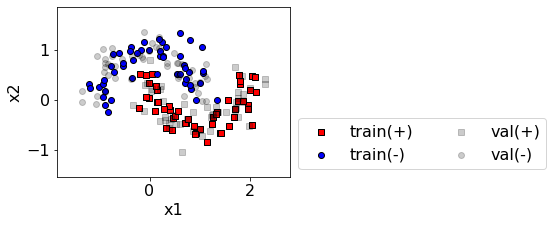

In [4]:
#@title データを表示します．
plot2cls(X, y, X_val=X_val, y_val=y_val).plot_data()

### ★scikit-learn を用いたロジスティック回帰

[sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)を使用した結果を出力します．

w0 = [0.1263125] ,  w = [ 1.15691641 -2.8461832 ]
Accuracy on training data:  0.86
Accuracy on validation data:  0.84


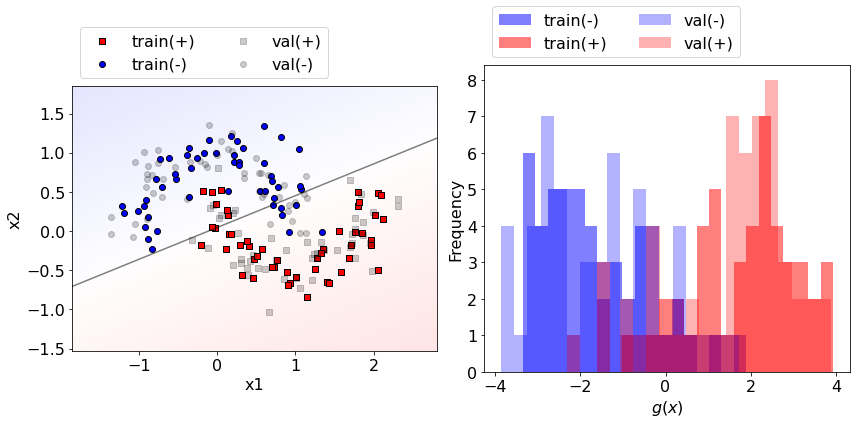

In [7]:
import sklearn
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()  #(penalty='none')
model.fit(X, y)

# print([w0], [w1, w2])
print("w0 =", model.intercept_, ",  w =", model.coef_.ravel())

print("Accuracy on training data: ", model.score(X, y))
print("Accuracy on validation data: ", model.score(X_val, y_val))

dec = lambda X: model.decision_function(X)
plot2cls(X, y, dec, X_val, y_val).plot_clf()

## 最急降下法によるロジスティック回帰の学習アルゴリズム
参考資料 [■](https://ml-cheatsheet.readthedocs.io/en/latest/logistic_regression.html) [■](https://math.stackexchange.com/questions/78575/derivative-of-sigmoid-function-sigma-x-frac11e-x)

適当な初期値から，学習率 $\alpha>0$ で $w_0$ と $\boldsymbol w$ の修正を次式のように反復します．

$\qquad w_0\gets w_0 - \alpha{\mathit\Delta}w_0$  
$\qquad \boldsymbol w\gets \boldsymbol w - \alpha{\mathit\Delta}\boldsymbol w$

修正量 ${\mathit\Delta}w_0$ と ${\mathit\Delta}\boldsymbol w$ は平均ロジスティック損失 $L(w_0,\boldsymbol w)$ の勾配で，次式のように表せます．

${\mathit\Delta}w_0=\;\;\;\frac{\partial L(w_0,\boldsymbol w)}{\partial w_0}\;\; = \frac{1}{n}\sum_{j=1}^n \varepsilon^{(j)}$  

${\mathit\Delta}\boldsymbol w=\left[\matrix{\frac{\partial L(w_0,\boldsymbol w)}{\partial w_1}\\ \vdots \\\frac{\partial L(w_0,\boldsymbol w)}{\partial w_d}}\right] = \frac{1}{n}\sum_{j=1}^n \varepsilon^{(j)}\boldsymbol x^{(j)}$  

ただし，
$\varepsilon^{(j)}=\left\{\begin{array}{cl}p^{(j)}-1 & (y^{(j)}=+1)\\ p^{(j)} & (y^{(j)}=-1)\end{array}\right.$  （確率 $p^{(j)}$ を正解 $y^{(j)}$ 比較した誤差）  

$[p^{(1)},\dots,p^{(n)}]=[\mathrm{sigmoid}(g(\boldsymbol x^{(1)})),\dots,\mathrm{sigmoid}(g(\boldsymbol x^{(n)}))]$  

です．つまり，データ $\boldsymbol x^{(j)}$ に対する識別関数の出力を確率 $p^{(j)}$ に換算し，
- 正解が $y^{(j)}=+1$ ならば $p^{(j)}$ が $1$ に近いほどよい（$\varepsilon^{(j)}=p^{(j)}-1$）
- 正解が $y^{(j)}=-1$ ならば $p^{(j)}$ が $0$ に近いほどよい（$\varepsilon^{(j)}=p^{(j)}$）

として誤差 $\varepsilon^{(j)}$ が計算されています．誤差が大きいほど修正量に加味されています．

## ★勾配降下法によるロジスティック回帰の実装

LogisticRegressionGDという名のクラスとして実装しましょう．[sklearn.linear_model.LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) に似た仕様とします．

訓練データ `X_train` とクラスラベル `y_train` を学習したあと，`X_val` のクラスラベルの予測 `y_pred` を得たり，正答率を表示するには，
```
    myclf = LogisticRegressionGD(lr=1e-2, max_iter=300)
    myclf.fit(X_train, y_train)
    y_pred = myclf.predict(X_val)
    print(myclf.score(X_val, y_val))
```
のように使うことを想定します．ここで，`lr` は学習率（learning rate），`max_iter` は反復回数（maximum number of iterations）です．
訓練データの次元数`d`，個数`n`の場合，`X_train` と `y_train` はそれぞれ shape が `(n,d)` と `(n,)` のNumPy配列です．ただし，`y_train` は2クラスを +1と-1で表すものとします．

In [8]:
from matplotlib.cbook import deprecation
import numpy as np

class LogisticRegressionGD:

    def __init__(self, lr=1., max_iters=1000):
        self.lr = lr
        self.max_iters = max_iters
        self.intercept_ = None                          # w0
        self.coef_ = None                               # [w1,...,wd}
        self.loss_history = []                          # 損失の履歴


    # 識別関数 g(x) = w0 + w1*x1 + ... + wd*xd
    def decision_function(self, X):                     # X(n,d)
        return ''' self.intercept_ と X.dot(self.coef_) を使う '''

    # シグモイド関数 sigmoid(z) = 1/ (1 + exp(-z))
    def _sigmoid(self, z):                              # z(n,)
        return ''' np.exp() を使う '''

    # 平均ロジスティック損失 (1/n)Σ log(1 + exp(-y*g(x)) )
    def ave_loss(self, X, y):                           # X(n,d), y(n,)
        loss = ''' self.decision_function(), np.log(), len(y) を使う '''
        return loss


    # 学習：勾配降下法で w0,...,wdを最適化します
    def fit(self, X, y):                                # X(n,d), y(n,)
        n, d = X.shape

        # w0 と [w1,...,wd] の初期化
        if self.intercept_ is None: self.intercept_ = 0
        if self.coef_ is None: self.coef_ = np.zeros(d)

        # 勾配降下の反復
        for _ in range(self.max_iters):
            p = ''' self.decision_function() と self._sigmoid() を使う．'''
            e = np.where(y > 0, p - 1, p)               # e(n,)

            dw0 = e.sum() / n
            dw = e.dot(X) / n

            self.intercept_ -= ''' self.lr と dw0 を使う '''
            self.coef_ -= ''' self.lr と dw を使う '''

            self.loss_history.append( self.ave_loss(X, y) )


    # 推論
    def predict(self, X):                               # X(n,d)
        y_pred = self.decision_function(X)              # y_pred(n,)
        return np.where(y_pred > 0, 1, -1)              # (n,)

    def score(self, X, y):
        y_pred = self.predict(X)
        return (y == y_pred).sum() / len(y)

### 実装した`LogisticRegressionGD`で識別します．

w0 = 0.5036213861553654 ,  w = [ 1.40579162 -4.89990981]
Accuracy on training data:  0.88
Accuracy on validation data:  0.84


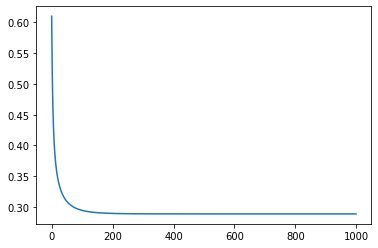

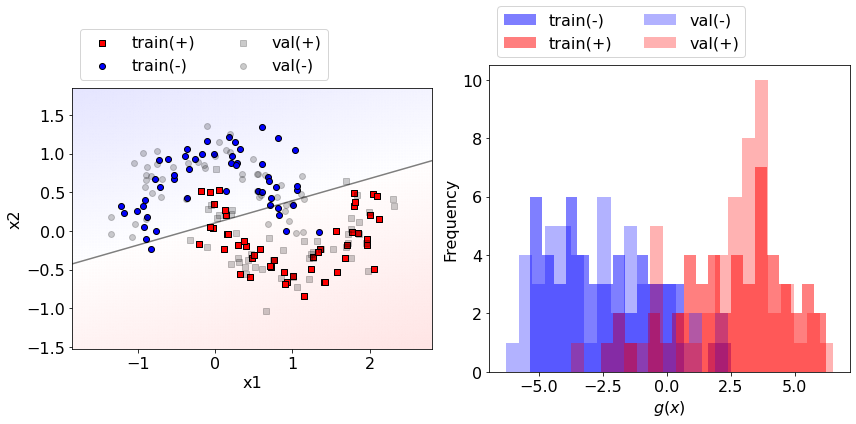

In [9]:
model = LogisticRegressionGD()  # lr=100.
model.fit(X, y)

# print([w0], [w1, w2])
print("w0 =", model.intercept_, ",  w =", model.coef_.ravel())

print("Accuracy on training data: ", model.score(X, y))
print("Accuracy on validation data: ", model.score(X_val, y_val))

plt.plot(model.loss_history)

dec = lambda X: model.decision_function(X)
plot2cls(X, y, dec, X_val, y_val).plot_clf()

--------
## 発展課題（任意）

学習率や反復回数を大きくした場合を考えましょう．  
最急降下法によるロジスティック回帰では，同じ問題設定でも scikit-learn の場合と決定境界が異なっていることを確認してください．特に，学習率や反復回数を大きくするほど，求まる重み（`w0` や `[w1,...,wd]`）の値が大きくなります．

    1. 重みの大きさと，平均ロジスティック損失の関係を説明してください．

（ここに回答を書いてください）


ヒント：平均ロジスティック損失 $L(w_0,\boldsymbol w)=\frac{1}{n}\sum_{j=1}^n\log\left(1+e^{-y^{(j)}(w_0+\boldsymbol w^\top\boldsymbol x^{(j)})}\right)$

    2. L2正則化を導入したアルゴリズムに変更し，scikit-learn と同じ結果を再現してください．

（ここに回答を書いてください）


ヒント：
- L2正則化項を付加した最小化問題： $\mathrm{Minimize}_{(w_0,\boldsymbol w)}\quad L(w_0,\boldsymbol w)+\frac{1}{2}\|\boldsymbol w\|_2^2\qquad$  （ただし，$\|\boldsymbol w\|_2^2=w_1^2+\cdots+w_d^2$）
- L2正則化項 $\frac{1}{2}\|\boldsymbol w\|_2^2$ の勾配は $\boldsymbol w$ なので， $\boldsymbol w$ の修正量 $\mathit\Delta\boldsymbol w$ が $\boldsymbol w$ だけ増える．
- fit を一行変更するだけで済む．$\boldsymbol w$ は `self.coef_` のこと．
- [scikit-learn の最小化問題は `n` で除さない仕様なので](https://scikit-learn.org/stable/modules/linear_model.html#binary-case)，平均ロジスティック損失を採用している場合は `self.coef_ / n` だけ修正量を増やす．


    3. L2正則化を導入したアルゴリズムでは，学習率を大きくすると，重みは大きくならないが，収束しなくなる．  
       このことを確認し，収束しない理由を説明してください．

（ここに回答を書いてください）



お疲れさまでした．